# VGG16 on the Fruits-360 Dataset

## Introduction

The reuse of a previously trained model on a new problem is known as transfer learning. It is particularly popular in deep learning right now since it can train deep neural networks with a small amount of data. Some of the popular pre-trained models are currently VGGs and ResNets. To get desired outputs from these pre-trained models, fine-tuning techniques need to be applied. These are famous transfer learning techniques for deep neural networks, where a few rounds of training are applied to the parameters of a pre-trained model to adapt them to a new task. Also, transfer learning is a quite suitable method for image classification because the low- and middle-layer features of images are almost the same. In this notebook, we are going to try to predict the fruits in the Fruits-360 dataset by using the VGG16 model. To do this, we will use a VGG16 model on the Fruits-360 dataset, and we will change the last layer of the model to get the desired outputs. Before training the model, let's import the required libraries and arrange the dataset.

**Note**: You can download the dataset from the link in the sources part.

**Note**: For people who are going to run the code in Google Colab, initially, you have to upload the dataset to your drive. Then, you need to run the code below.

In [1]:
# make connection to drive and unzip the dataset

from google.colab import drive

drive.mount("/content/drive")

!unzip -u "/content/drive/My Drive/fruits-360.zip" -d "/content/tmp"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_290_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_291_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_292_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_293_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_294_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_295_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_296_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_297_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_298_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_299_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_2_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_300_100.jpg  
  inflating: /content/tmp/fruits-360/Training/Tomato 2/r_301_100.jpg  
  inflating: /content/tmp/fruits

In [2]:
# import the required libraries

# to import the VGG16 model
from keras.applications.vgg16 import VGG16

# to create a customized VGG16 model
from keras.models import Sequential
from keras.layers import Dense, Dropout

# optimizer
from keras.optimizers import Adam

# to preprocess the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# to count the number of classes
from glob import glob

# to visualize the images
import matplotlib.pyplot as plt

# to get rid of the possible warnings
import warnings
warnings.filterwarnings("ignore")

## Image Preprocessing

Fruits-360 is a dataset that contains 131 different fruit folders, and each folder contains a specific fruit images. To import the dataset, firstly, we need to define the paths of folders.

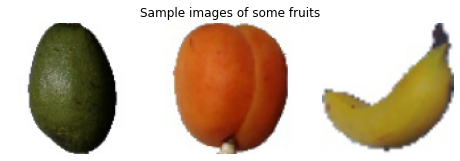

In [3]:
# define the paths and visualize some sample images

trainPath = r"/content/tmp/fruits-360/Training/"
testPath = r"/content/tmp/fruits-360/Test/"

img1 = load_img(trainPath + "Avocado/0_100.jpg")
img2 = load_img(trainPath + "Apricot/0_100.jpg")
img3 = load_img(trainPath + "Banana/0_100.jpg")

fig, ax = plt.subplots(1, 3, figsize = (8, 4))

ax[0].imshow(img1)
ax[0].axis("off")

ax[1].imshow(img2)
ax[1].axis("off")
ax[1].set_title("Sample images of some fruits")

ax[2].imshow(img3)
ax[2].axis("off")

plt.show()

According to the dataset description, the shape of each image is (100, 100, 3), and there are 131 different fruits in total.

In [4]:
# define the images shape and number of classes

shapeOfImgs = (100, 100, 3) # We know this from the dataset description
numOfClasses = len(glob(trainPath + "/*"))

print("The shape of images:", shapeOfImgs)
print("The number of classes:", numOfClasses)

The shape of images: (100, 100, 3)
The number of classes: 131


When looking the VGG16 model architecture, we see that input size of the model is (224, 224, 3). However, Fruits-360 images are (100, 100, 3), so we need to resize the fruit images. Then, to avoid over-fitting, we have to do some image augmentation.

In [5]:
# arrange the data for the model

batchSize = 32
shapeForVgg16 = (224, 224, 3)

trainData = ImageDataGenerator(rotation_range = 60,
                               width_shift_range = 0.25,
                               height_shift_range = 0.25,
                               shear_range = 0.25,
                               zoom_range = 0.25,
                               fill_mode = "nearest").flow_from_directory(trainPath,
                                                                          target_size = (shapeForVgg16[0], shapeForVgg16[1]))
testData = ImageDataGenerator().flow_from_directory(testPath, 
                                                    target_size = (shapeForVgg16[0], shapeForVgg16[1]))

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Now, the training and test images are ready to go into the model. After this step, we will use the VGG16 model by changing the last fully connected layer in it.

## VGG16

In this part, VGG16 model of which the last layer are changed to be trainable is going to be used for the training process. Before creating the model, let's first define the number of epochs for the models.

In [6]:
# define the number of epochs

numOfEpochs = 50

Let's examine the VGG16 architecture right now. There are three fully connected layers and five separate convolution blocks, as seen in the figure below. According to transfer learning, all layers are typically frozen, with the exception of the fully connected ones, which are configured for a particular job. For the sake of simplicity, we will build a model by altering just the final fully connected layer, which is decision layer. Let's now begin training the model. The only change we will do on the model is the output size. Since VGG16 is a pre-trained model with the ImageNet dataset, which has 1000 classes, we need to change the output size as 131.

<div align = "center">
<img title = "VGG16 Architecture" alt = "Alt text" src = "https://miro.medium.com/max/1400/1*NNifzsJ7tD2kAfBXt3AzEg.png" width = 500 height = 300>
</div>
    
To import the model, we use Keras. You can examine the architecture in detail below.
    
**Note**: To understand the VGG16 model deeply, you can examine the following link: https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

In [7]:
# import the VGG16 model from Keras and change the output size

vgg16 = VGG16(include_top = True, weights = "imagenet", input_shape = shapeForVgg16)

vgg16_v1 = Sequential()
vgg16_v1._name = "vgg16_v1"

for i in range(len(vgg16.layers) - 1):
    vgg16_v1.add(vgg16.layers[i])
    
for layer in vgg16.layers:
    layer.trainable = False
    
vgg16_v1.add(Dense(numOfClasses, activation = "softmax"))

print(vgg16_v1.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "vgg16_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                         

Let's define the optimizer and loss function. In this notebook, we will use **"Adam"** as the optimizer, and **"categorical_crossentropy"** as the loss function. Then, let's start to train the model, and plot the results.

In [8]:
# define the optimizer and loss function, and compile the model

optimizer = Adam(learning_rate = 0.001)

vgg16_v1.compile(loss = "categorical_crossentropy", 
                 optimizer = optimizer, 
                 metrics = ["accuracy"])

In [9]:
# train and save the model

hist_v1 = vgg16_v1.fit(trainData, 
                       steps_per_epoch = 1600//batchSize, 
                       epochs = numOfEpochs, 
                       validation_data = testData, 
                       validation_steps = 800//batchSize)

vgg16_v1.save("/content/vgg16_v1.h5")

Epoch 1/50
50/50 [==============================] - 35s 491ms/step - loss: 4.1996 - accuracy: 0.2925 - val_loss: 2.4235 - val_accuracy: 0.4675
Epoch 2/50
50/50 [==============================] - 25s 503ms/step - loss: 1.5646 - accuracy: 0.5888 - val_loss: 1.8412 - val_accuracy: 0.6000
Epoch 3/50
50/50 [==============================] - 26s 520ms/step - loss: 1.0627 - accuracy: 0.6894 - val_loss: 1.7896 - val_accuracy: 0.6263
Epoch 4/50
50/50 [==============================] - 26s 519ms/step - loss: 0.9643 - accuracy: 0.7412 - val_loss: 1.2288 - val_accuracy: 0.7175
Epoch 5/50
50/50 [==============================] - 26s 521ms/step - loss: 0.7857 - accuracy: 0.7688 - val_loss: 1.5625 - val_accuracy: 0.6925
Epoch 6/50
50/50 [==============================] - 26s 521ms/step - loss: 0.7404 - accuracy: 0.7894 - val_loss: 1.3644 - val_accuracy: 0.7225
Epoch 7/50
50/50 [==============================] - 26s 515ms/step - loss: 0.6995 - accuracy: 0.7987 - val_loss: 1.4071 - val_accuracy: 0.7038

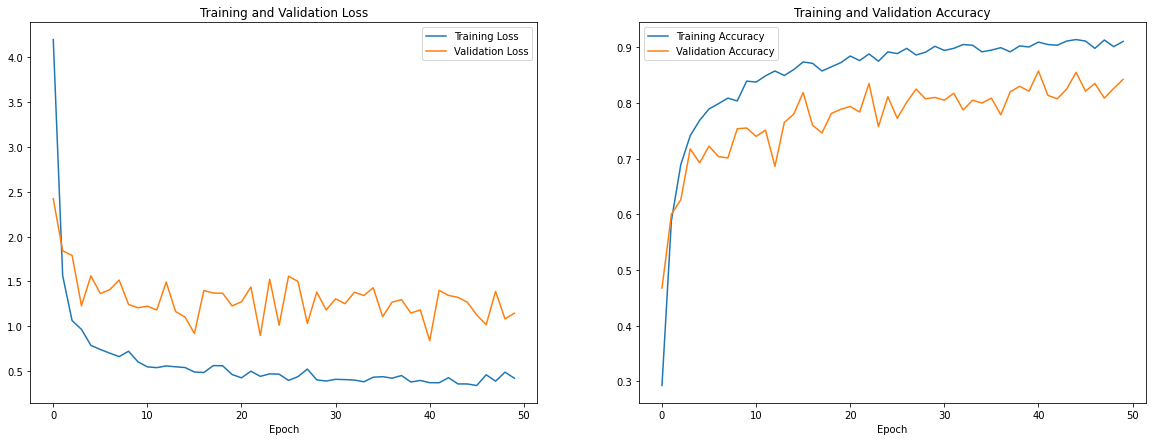

In [10]:
# visualize the result

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(hist_v1.history["loss"], label = "Training Loss")
ax[0].plot(hist_v1.history["val_loss"], label = "Validation Loss")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(hist_v1.history["accuracy"], label = "Training Accuracy")
ax[1].plot(hist_v1.history["val_accuracy"], label = "Validation Accuracy")
ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.show()

When looking at the graphs, it seems that the model can predict an image in the Fruits-360 dataset with around 85%  accuracy. Also, a small overfitting problem has occurred, but since the model has already been trained with the ImageNet dataset and we trained only the last layer, it is quite normal. Nevertheless, you can decrease the effects of this problem by adding some dropout layers or diversifying the inputs.

For some of you who are interested in VGG16 in Pytorch, you can examine the code below.

In [11]:
# import the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# define the blocks of VGG16

def double_conv(in_planes, out_planes):
    return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size = 3, padding = 1),
                         nn.ReLU(inplace = True), 
                         nn.Conv2d(out_planes, out_planes, kernel_size = 3, padding = 1),
                         nn.ReLU(inplace = True),
                         nn.MaxPool2d(kernel_size = 2, stride = 2))


def triple_conv(in_planes, out_planes):
    return nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size = 3, padding = 1),
                         nn.ReLU(inplace = True), 
                         nn.Conv2d(out_planes, out_planes, kernel_size = 3, padding = 1),
                         nn.ReLU(inplace = True),
                         nn.Conv2d(out_planes, out_planes, kernel_size = 3, padding = 1),
                         nn.ReLU(inplace = True),
                         nn.MaxPool2d(kernel_size = 2, stride = 2))

In [13]:
# define the VGG16 class

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        self.block1 = double_conv(3, 64)
        self.block2 = double_conv(64, 128)
        self.block3 = triple_conv(128, 256)
        self.block4 = triple_conv(226, 512)
        self.block5 = triple_conv(512,512)
        
        self.fc1 = nn.Linear(7 * 7 * 512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, numOfClasses)
        
        self.relu = nn.ReLU(inplace = True)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        
        out = self.flatten(out)
        
        out = self.fc1(out)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        
        return out
    
vgg16= VGG16()

## Conclusion

In this notebook, we built the VGG16 model to predict the images in the Fruits-360 dataset. The only change in the model was the last fully connected layer. We changed this layer to get the outputs we wanted, and we got around 85% accuracy.

## Sources

* **Dataset**: https://www.kaggle.com/datasets/moltean/fruits
* **Useful Links**:
  * https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
  * https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918